<a href="https://colab.research.google.com/github/karyapoormohamadie/stock_market_model/blob/main/stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [ ]:
now = str(datetime.datetime.now())[:10]

df = yf.download('GOOGL','2018-01-01',now,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
import requests
url = 'https://www.alphavantage.co/query?function=RSI&symbol=GOOGL&interval=daily&time_period=5&series_type=close&apikey=OHY3DST217RX6SV7'
response = requests.get(url)
rsi = response.json()

In [ ]:
rsi_data = pd.DataFrame.from_dict(rsi['Technical Analysis: RSI'] , orient='index')
rsi_data = rsi_data[rsi_data.index >= '2018-01-01']
rsi_data['RSI'] = rsi_data['RSI'].astype(np.float64)

<ipython-input-4-14ff4d69ee71>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rsi_data['RSI'] = rsi_data['RSI'].astype(np.float64)


In [ ]:
rsi_data.index = pd.to_datetime(rsi_data.index)

In [ ]:
data = pd.concat([df,rsi_data],axis=1 )

In [ ]:
data.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
RSI,0


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,RSI
count,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1.694000e+03,1694.000000
mean,98.649143,99.753286,97.602089,98.699839,98.466264,3.406985e+07,54.642050
std,36.880686,37.228879,36.534177,36.874691,36.803037,1.532962e+07,19.102530
min,49.216000,50.605999,48.882999,49.233501,49.111893,9.312000e+06,6.772100
25%,61.180500,61.812750,60.692874,61.153126,61.002076,2.427300e+07,40.303225
50%,96.305000,98.295002,94.879997,96.350002,96.112015,3.031615e+07,56.100150
75%,131.410004,133.000000,129.852623,131.399994,131.075424,3.885100e+07,69.678175
max,190.309998,191.750000,189.029999,191.179993,190.926636,1.331780e+08,94.243300


In [ ]:
data.corr()

,Open,High,Low,Close,Adj Close,Volume,RSI
Open,1.000000,0.999652,0.999625,0.999184,0.999186,-0.242289,0.010770
High,0.999652,1.000000,0.999586,0.999620,0.999620,-0.235978,0.014814
Low,0.999625,0.999586,1.000000,0.999668,0.999669,-0.251649,0.023497
Close,0.999184,0.999620,0.999668,1.000000,0.999999,-0.245233,0.026991
Adj Close,0.999186,0.999620,0.999669,0.999999,1.000000,-0.245262,0.026915
Volume,-0.242289,-0.235978,-0.251649,-0.245233,-0.245262,1.000000,-0.174618
RSI,0.010770,0.014814,0.023497,0.026991,0.026915,-0.174618,1.000000


In [ ]:
data = data.sort_index()
data

,Open,High,Low,Close,Adj Close,Volume,RSI
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.527958,31766000,65.4310
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.441196,31318000,78.3686
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.652668,26052000,80.4830
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.377377,30250000,86.2429
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.572891,24644000,87.4882
...,...,...,...,...,...,...,...
2024-09-19,163.710007,163.789993,161.339996,162.139999,162.139999,26587700,78.6820
2024-09-20,163.500000,163.729996,162.059998,163.589996,163.589996,40896400,82.2636
2024-09-23,164.350006,165.490005,161.669998,161.850006,161.850006,24150900,65.7051
2024-09-24,163.029999,163.220001,160.690002,162.289993,162.289993,23332100,67.7566


<Axes: ylabel='Volume'>

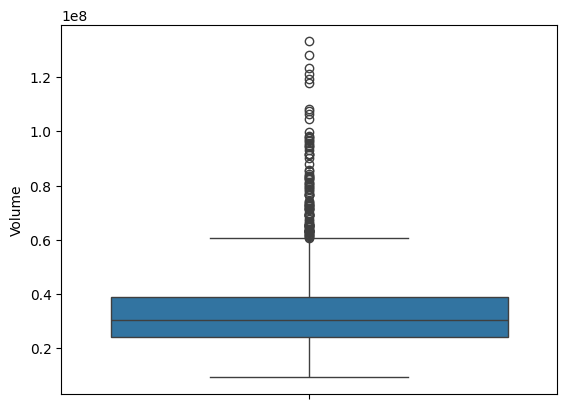

In [ ]:
sns.boxplot(data.Volume)

In [ ]:
import plotly.graph_objects as go

In [ ]:
def tracer(Y):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=data.index,y=Y,mode='lines'))

  fig.show()

In [ ]:
tracer(data['Open'])

In [ ]:
tracer(data['Close'])

In [ ]:
data = data[['Close','Open','RSI']]
data

,Close,Open,RSI
2018-01-02,53.660500,52.651001,65.4310
2018-01-03,54.576000,53.696499,78.3686
2018-01-04,54.787998,54.854500,80.4830
2018-01-05,55.514500,55.172501,86.2429
2018-01-08,55.710499,55.549999,87.4882
...,...,...,...
2024-09-19,162.139999,163.710007,78.6820
2024-09-20,163.589996,163.500000,82.2636
2024-09-23,161.850006,164.350006,65.7051
2024-09-24,162.289993,163.029999,67.7566


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tnrange
import pickle

In [ ]:
1677 * 0.2

335.40000000000003

In [ ]:
test_lengh = data[(data.index > '2023-01-01')].shape[0]
test_lengh

435

In [ ]:
def create_featurs(data,feature_length):

  x=[]
  y=[]

  for i in tnrange(len(data) - feature_length):
    x.append(data.iloc[i : i + feature_length].values)
    y.append(data['Close'].values[i + feature_length])

  x = np.array(x)
  y = np.array(y)

  return x,y



In [ ]:
x , y = create_featurs(data,32)

  0%|          | 0/1662 [00:00<?, ?it/s]

In [ ]:
x_train , x_test , y_train , y_test = x[:-test_lengh] , x[-test_lengh:] ,y[:-test_lengh] , y[-test_lengh:]

In [ ]:
class MultiDimentionScaler():
  def __init__(self):
    self.scalers = []

  def fit_transform(self , X):
    total_dim = X.shape[2]
    for i in range(total_dim):
      Scaler = MinMaxScaler()
      X[:,:,i] = Scaler.fit_transform(X[:,:,i])
      self.scalers.append(Scaler)
    return X

  def transform(self,X):
    for i in range(X.shape[2]):
      X[:,:,i] = self.scalers[i].transform(X[:,:,i])
    return X



In [ ]:
feature_scaler = MultiDimentionScaler()

x_train = feature_scaler.fit_transform(x_train)
x_test = feature_scaler.transform(x_test)


In [ ]:
target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(y_train.reshape(-1,1))
y_test = target_scaler.transform(y_test.reshape(-1,1))


In [ ]:
def save(obj ,name:str):
  path = open(f'{name}.pck','wb')
  pickle.dump(obj,path)
  path.close

def load(obj,name):
  path = open(f'{name}.pck','rb')
  lo = pickle.load(path)
  return lo

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau

checkpoint = ModelCheckpoint('/content/drive/MyDrive/checkpoint/model.weights.h5',monitor = 'val_loss',mode='min',save_best_only=True,save_weights_only=True)
learn_rate_reducer = ReduceLROnPlateau(factor = 0.25,patience=3,min_lr=0.0001)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf


model = Sequential()

model.add(layers.Input((32,3)))

model.add(layers.Bidirectional(layers.LSTM(512,return_sequences=True,recurrent_dropout=0.1)))
model.add(layers.LSTM(256,recurrent_dropout=0.1))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64,activation='elu'))
model.add(layers.Dense(32,activation='elu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(32,activation='elu'))
model.add(layers.Dense(1,activation='linear'))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),loss='mse')


In [ ]:
x_train.shape,x_test.shape

((1227, 32, 3), (435, 32, 3))

In [ ]:
model.fit(x_train,y_train
          ,epochs=30,
          verbose=1,
          batch_size=1,
          validation_data=(x_test,y_test),
          callbacks=[checkpoint,learn_rate_reducer],
          shuffle=False)

Epoch 1/30
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 127s 100ms/step - loss: 0.0026 - val_loss: 0.3293 - learning_rate: 0.0050
Epoch 2/30
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 138s 99ms/step - loss: 0.0056 - val_loss: 0.3239 - learning_rate: 0.0050
Epoch 3/30
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 139s 97ms/step - loss: 0.0062 - val_loss: 0.3095 - learning_rate: 0.0050
Epoch 4/30
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 145s 99ms/step - loss: 0.0062 - val_loss: 0.2950 - learning_rate: 0.0050
Epoch 5/30
 488/1227 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - loss: 0.0108

KeyboardInterrupt: 

In [ ]:
model = tf.keras.Model()
model.load_weights('/content/drive/MyDrive/checkpoint/model.weights.h5')
prediction = model.predict(x_test)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/checkpoint/model.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
prediction = target_scaler.inverse_transform(prediction)
actual = target_scaler.inverse_transform(y_test)

In [ ]:
prediction.shape,prediction[0]

((418, 1), array([90.76945], dtype=float32))

In [ ]:
prediction = np.squeeze(prediction,axis=1)
actual = np.squeeze(actual,axis=1)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index[-test_lengh:],y=prediction , mode='lines',name='predicted'))
fig.add_trace(go.Scatter(x=data.index[-test_lengh:],y=actual , mode='lines',name='actual'))

fig.show()